In [136]:
from collections import deque
import random
from itertools import combinations, permutations

In [54]:
import nbimporter
from fct_usuelles import lire_graphe, afficher_graphe, visualiser_graphe_par_etape

prends en paramètre un graphe dans un état (càd avec des sommets brulés) et retourne le graphe dans l'état suivante

In [55]:
def successeurs(graphe, etat_actuel):
    """
    Génère l'état suivant en propageant la brûlure aux voisins des sommets déjà brûlés.
    :param graphe: Le graphe sous forme de dictionnaire.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: Nouveau dictionnaire représentant l'état des sommets après propagation.
    """

    brulage = False  # Indique si un sommet a été brûlé dans cet appel de la fonction

    # Copier l'état actuel pour générer le nouvel état
    nouvel_etat = etat_actuel.copy()

    # Récupérer tous les sommets brûlés
    sommets_brules = [sommet for sommet, etat in nouvel_etat.items() if etat == "brulé"]

    # Propager la brûlure aux voisins des sommets brûlés
    for sommet in sommets_brules:
        for voisin in graphe.get(sommet, []):  # Obtenir les voisins dans la liste d'adjacence
            if nouvel_etat[voisin] == "non brûlé":  # Brûler uniquement les sommets non brûlés
                nouvel_etat[voisin] = "brulé"
                brulage = True

    return nouvel_etat, brulage

test_but : vérifie si tout les sommets sont brulées

In [56]:
def test_but(etat_actuel):
    """
    Vérifie si tous les sommets du graphe sont brûlés.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: True si tous les sommets sont brûlés, False sinon.
    """
    return all(etat == "brulé" for etat in etat_actuel.values())


In [57]:
def choisir_sommet_a_bruler(graphe, etat_actuel):
    """
    Sélectionne un sommet non brûlé ayant le maximum de voisins.
    
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets.
    :return: Le sommet non brûlé avec le maximum de voisins, ou None si aucun sommet disponible.
    """
    # Trouver les sommets non brûlés
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == "non brûlé"]
    
    if not sommets_non_brules:
        # Aucun sommet non brûlé
        return None

    # Trouver le sommet avec le maximum de voisins
    sommet_max_voisins = max(sommets_non_brules, key=lambda sommet: len(graphe.get(sommet, [])))

    return sommet_max_voisins


In [58]:
def choisir_sommet_aleatoire(etat_actuel):
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == "non brûlé"]
    return random.choice(sommets_non_brules) if sommets_non_brules else None


## 1ère méthode

In [59]:
def recherche_profondeur(graphe, etat_initial, successeurs, test_but):
    """
    Algorithme générique de recherche pour brûler un graphe en choisissant un sommet par étape.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : créer la liste des états à traiter
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 0, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état
        noeud = etats_a_traiter.pop()

        noeud["etat"], brulage = successeurs(graphe, noeud["etat"])

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["brules_actifs"], noeud["cout"]

        # Choisir un nouveau sommet à brûler activement
        nouveau_sommet = choisir_sommet_a_bruler(graphe, noeud["etat"])
        #nouveau_sommet = choisir_sommet_aleatoire(noeud["etat"])
        if nouveau_sommet is None:
            # Si aucun sommet à brûler n'est disponible, retourner l'état actuel
            continue

        # Marquer le nouveau sommet comme "brûlé"
        etat_suivant = noeud["etat"].copy()
        etat_suivant[nouveau_sommet] = "brulé"

        # Ajouter le nouvel état à la liste des états à traiter
        etats_a_traiter.append({
            "etat": etat_suivant,
            "cout": noeud["cout"] + 1,  # Chaque étape coûte 1
            "brules_actifs": noeud["brules_actifs"] + [nouveau_sommet]
        })

    # Si aucun état final n'est trouvé
    return [], float("inf")


etape 1 :

parcours en largeur : popleft de la liste des états à traiter

parcours en largeur itéré : livre artificial intelligence section 3.4.4 et 3.4.5


etape 2 : couverture des balles

appliquer le A* dans le parcours

bruler ce noeuds pendant un certain temps
=> couverture par des balles

l'ensemble des action : 
le cout : la taille de la grande balle
fixer burning number dés le début (6)


# 2éme méthode

In [60]:
def recherche_largeur(graphe, etat_initial, successeurs, test_but):
    """
    Algorithme générique de recherche en largeur pour brûler un graphe.
    À chaque étape, chaque sommet est exploré pour générer tous les états possibles.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : file (FIFO) pour gérer les états à traiter
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 0, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état de la file (FIFO)
        noeud = etats_a_traiter.popleft()

        # Propager l'état courant (brûlage des voisins déjà brûlés)
        noeud["etat"], brulage = successeurs(graphe, noeud["etat"])

        noeud["cout"] += 1  # Chaque étape coûte 1

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["brules_actifs"], noeud["cout"]

        # Générer tous les nouveaux états possibles en brûlant chaque sommet non brûlé
        for sommet in graphe:
            if noeud["etat"].get(sommet) != "brulé":  # Si le sommet n'est pas encore brûlé
                # Copier l'état courant
                etat_suivant = noeud["etat"].copy()

                # Marquer le sommet comme "brûlé"
                etat_suivant[sommet] = "brulé"

                # Ajouter le nouvel état à la file
                etats_a_traiter.append({
                    "etat": etat_suivant,
                    "cout": noeud["cout"],
                    "brules_actifs": noeud["brules_actifs"] + [sommet]
                })

    # Si aucun état final n'est trouvé
    return [], float("inf")


In [145]:
# 10 sommets (3.16)
#fichier = r'instances\Stranke94\Stranke94.mtx'

# 29 sommets (5.38)
#fichier = r'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.mtx'

# 34 sommets (5,83)
fichier = r'instances\karate\karate.mtx'

# 7057 sommets (84.005)
#fichier = r'instances\fb-pages-government\fb-pages-government.mtx'

# 11631 sommets (107.84)
#fichier = r'instances\web-wiki-crocodile\web-wiki-crocodile.mtx'

# 196 591 sommets (443.38)
#fichier = r'instances\loc-gowalla_edges\loc-gowalla_edges.mtx'

# Charger un graphe avec la fonction lire_graphe
graphe = lire_graphe(fichier)

In [86]:
#graphe = {1: [2, 3], 2: [1, 4], 3: [1, 4], 4: [2, 3]}

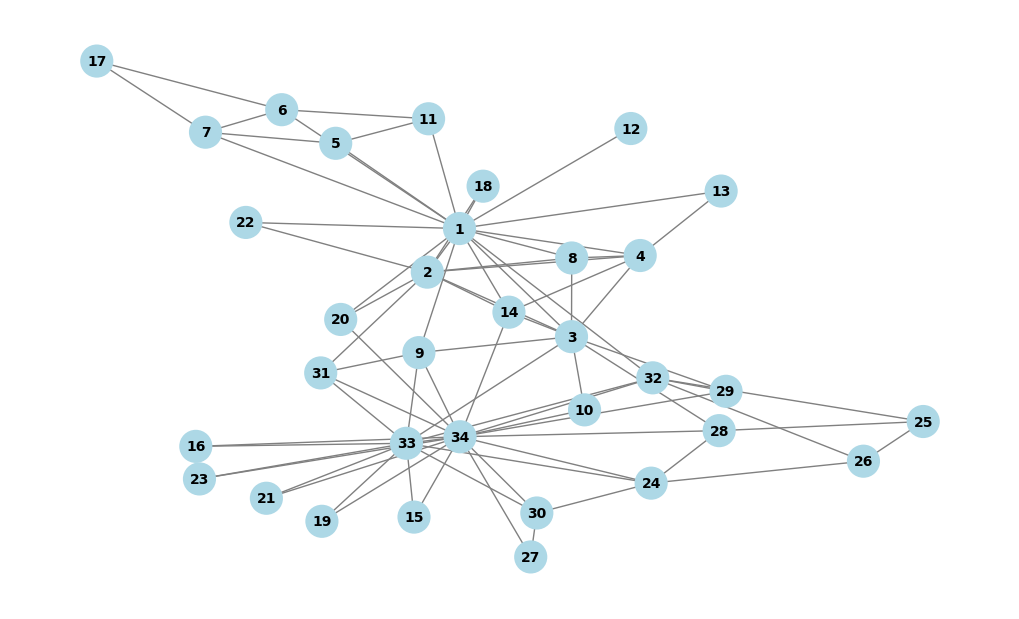

In [146]:
afficher_graphe(graphe)

In [144]:
etat_initial = {sommet: "non brûlé" for sommet in graphe}

sommets_actifs, cout = recherche_profondeur(graphe, etat_initial, successeurs, test_but)

print("*********** Parcours en profondeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs)
print("Coût total:", cout)
print("\n")

sommets_actifs, cout = recherche_largeur(graphe, etat_initial, successeurs, test_but)

print("*********** Parcours en largeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs)
print("Coût total:", cout)

*********** Parcours en profondeur ***********
Sommets brûlés à chaque étape: [5320, 6615, 1434, 5114, 4396, 467]
Coût total: 6




MemoryError: 

dire un sommet va etre brulé au 3 tour par exemple
notre solution (du 2eme algo) sera le  centre (sommet) de la boule ayant le rayon le plus grand

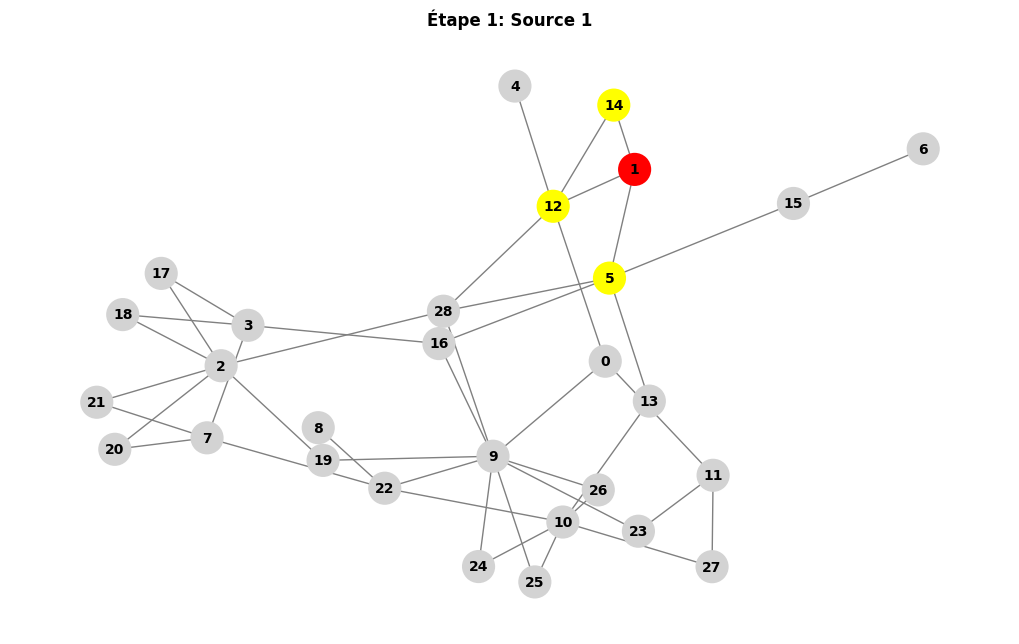

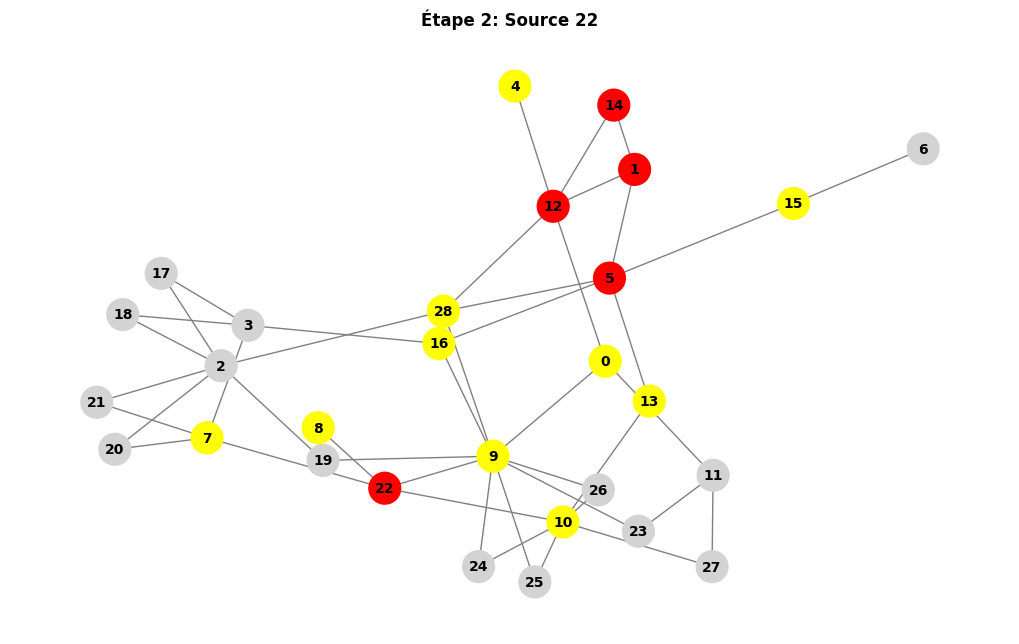

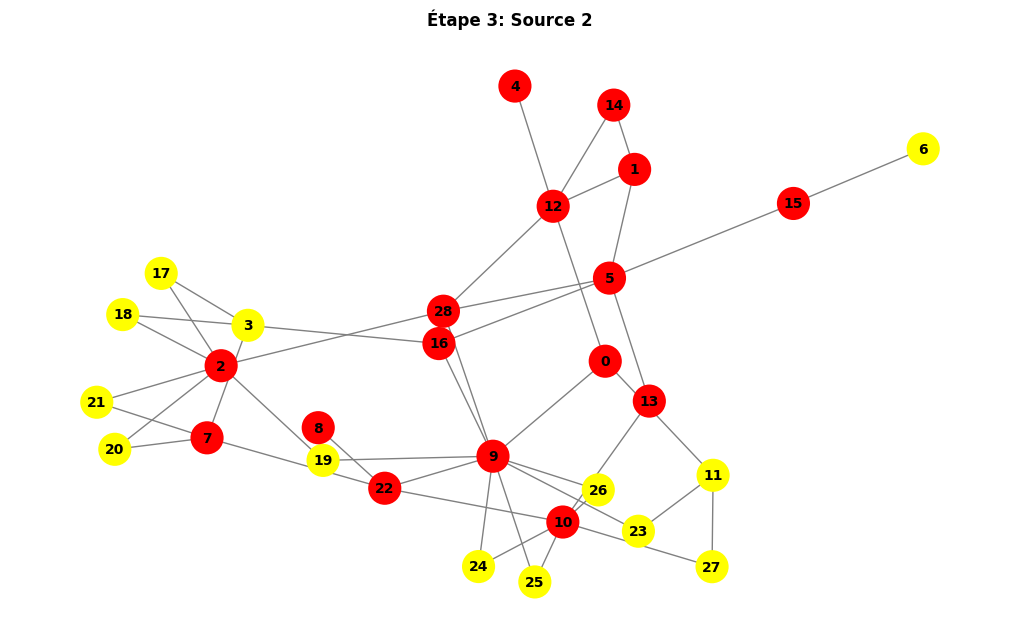

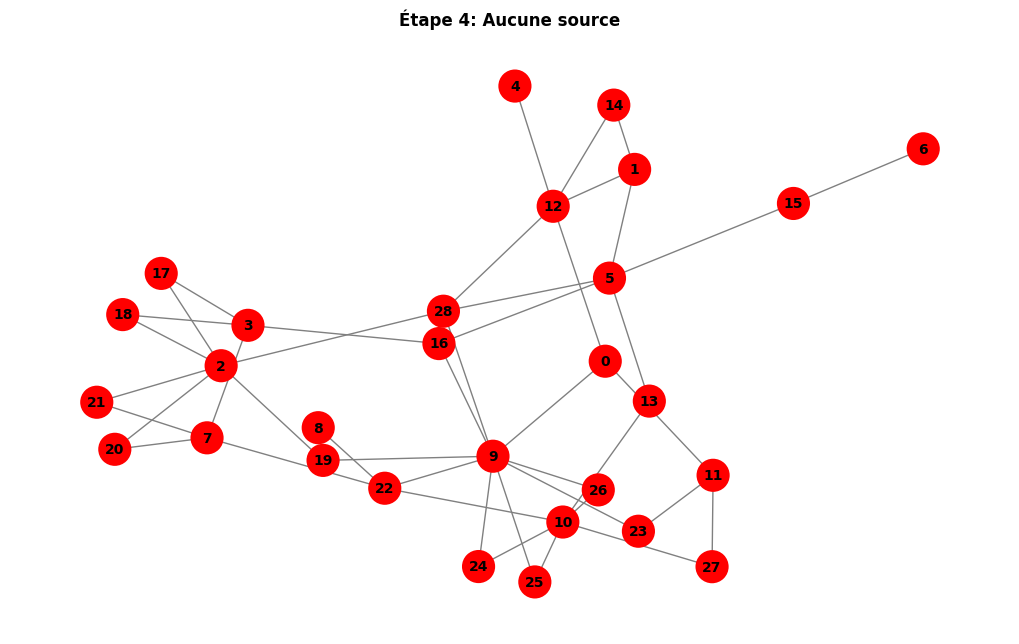

In [94]:
# Visualiser le graphe par étape
visualiser_graphe_par_etape(graphe, sommets_actifs)


# Couverture des balles

### Définition clarifiée des balles :
1. **Rayon de la balle** :
   - Le rayon $ r $ détermine combien de niveaux de voisins (profondeur dans le graphe) la balle peut atteindre depuis son centre $ U $.
   - Par exemple :
     - Rayon 1 : Brûle uniquement les voisins directs de $ U $.
     - Rayon 2 : Brûle les voisins de $ U $ et les voisins des voisins de $ U $.

2. **Centre de la balle** :
   - Chaque balle a un centre $ U $, qui est un sommet du graphe. À partir de ce centre, la brûlure se propage jusqu’à une profondeur $ r $.

3. **Objectif** :
   - Trouver un ensemble de balles ($ U_i, r_i $) qui couvrent **tout le graphe**.
   - Chaque sommet du graphe doit être brûlé par au moins une balle.

4. **Contraintes** :
   - Les **rayons des balles doivent être différents**.
   - Toutes les combinaisons possibles de balles (centres et rayons) doivent être explorées pour garantir que le graphe est entièrement couvert.

5. **Propagation de la brûlure** :
   - La propagation de la brûlure à une profondeur $ r $ peut être simulée par un parcours en largeur (BFS) depuis le sommet $ U $, en limitant la profondeur de l’exploration à $ r $.

In [95]:
def bruler_balle(graphe, centre, rayon):
    """
    Brûle les sommets atteints par une balle avec un centre et un rayon donné.
    :param graphe: Dictionnaire représentant le graphe (liste d'adjacence).
    :param centre: Le sommet central de la balle.
    :param rayon: Le rayon de la balle (profondeur de propagation).
    :return: Ensemble des sommets brûlés par la balle.
    """
    sommets_brules = set()
    queue = [(centre, 0)]  # (sommet, profondeur actuelle)
    visited = set()

    while queue:
        sommet, profondeur = queue.pop(0)
        if profondeur > rayon or sommet in visited:
            continue
        visited.add(sommet)
        sommets_brules.add(sommet)
        queue.extend((voisin, profondeur + 1) for voisin in graphe.get(sommet, []))

    return sommets_brules

In [96]:
def couverture_par_balles(graphe):
    """
    Trouve un ensemble de balles pour couvrir tout le graphe.
    :param graphe: Dictionnaire représentant le graphe (liste d'adjacence).
    :return: Liste des balles utilisées (centre, rayon).
    """
    sommets = list(graphe.keys())
    n = len(sommets)
    solution = []

    # Générer toutes les combinaisons possibles de rayons uniques
    for k in range(1, n + 1):  # Essayer avec 1 à n balles
        rayons = list(range(1, k + 1))  # Rayons uniques
        for centres in combinations(sommets, k):  # Choisir k centres
            combinaison = list(zip(centres, rayons))  # Associer chaque centre à un rayon
            sommets_couverts = set()

            # Appliquer toutes les balles
            for centre, rayon in combinaison:
                sommets_couverts.update(bruler_balle(graphe, centre, rayon))

            # Vérifier si tous les sommets sont couverts
            if len(sommets_couverts) == n:
                #solution.append(combinaison)
                return combinaison  # Retourner la première solution valide trouvée

    return None  # Aucune solution trouvée
    #return solution  # Aucune solution trouvée

In [135]:
list(combinations(["A", "B", "C"], 2))

[('A', 'B'), ('A', 'C'), ('B', 'C')]

In [122]:
# Données d'entrée
list1 = ["A", "B", "C"]
list2 = [1, 2, 3]

# Générer toutes les permutations des éléments de la première liste
result = [list(zip(perm, list2)) for perm in permutations(list1)]


result

[[('A', 1), ('B', 2), ('C', 3)],
 [('A', 1), ('C', 2), ('B', 3)],
 [('B', 1), ('A', 2), ('C', 3)],
 [('B', 1), ('C', 2), ('A', 3)],
 [('C', 1), ('A', 2), ('B', 3)],
 [('C', 1), ('B', 2), ('A', 3)]]

In [139]:
def couverture_par_balles_equilibree(graphe):
    """
    Trouve un ensemble de balles équilibré pour couvrir tout le graphe.
    :param graphe: Dictionnaire représentant le graphe (liste d'adjacence).
    :return: Liste des balles utilisées (centre, rayon).
    """
    sommets = list(graphe.keys())
    n = len(sommets)
    r_max = int(n**0.5)  # Fixer un rayon maximal pour une balle (critère d'équilibre)

    # Générer toutes les combinaisons possibles de rayons uniques
    for k in range(1, r_max):  # Essayer avec 1 à r_max balles
        rayons = list(range(1, r_max + 1))  # Rayons uniques
        for centres in combinations(sommets, k):  # Choisir k centres
            combinaison_permutations = [list(zip(perm, rayons)) for perm in permutations(centres)]
            
            # Appliquer toutes les permutations de combinaisons
            for combinaison in combinaison_permutations:
                sommets_couverts = set()

                # Appliquer toutes les balles
                for centre, rayon in combinaison:
                    if rayon > r_max:
                        continue  # Exclure les balles avec un rayon trop grand
                    sommets_couverts.update(bruler_balle(graphe, centre, rayon))

                # Vérifier si tous les sommets sont couverts
                if len(sommets_couverts) == n:
                    # Vérifier qu'aucune balle unique ne couvre tout le graphe
                    if not any(
                        len(bruler_balle(graphe, centre, rayon)) == n
                        for comb in combinaison_permutations
                        for centre, rayon in comb
                    ):
                        return combinaison  # Retourner la première solution valide équilibrée trouvée

    return None  # Aucune solution trouvée


In [147]:
solution = couverture_par_balles(graphe)
if solution:
    print("Solution trouvée :", solution)
    for centre, rayon in solution:
        print(f"Balle : Centre = {centre}, Rayon = {rayon}")
else:
    print("Aucune solution valide trouvée.")

print("\n")
solution = couverture_par_balles_equilibree(graphe)
if solution:
    print("Solution trouvée :", solution)
    for centre, rayon in solution:
        print(f"Balle : Centre = {centre}, Rayon = {rayon}")
else:
    print("Aucune solution valide trouvée.")

Solution trouvée : [(6, 1), (32, 2)]
Balle : Centre = 6, Rayon = 1
Balle : Centre = 32, Rayon = 2


Solution trouvée : [(34, 1), (1, 2)]
Balle : Centre = 34, Rayon = 1
Balle : Centre = 1, Rayon = 2


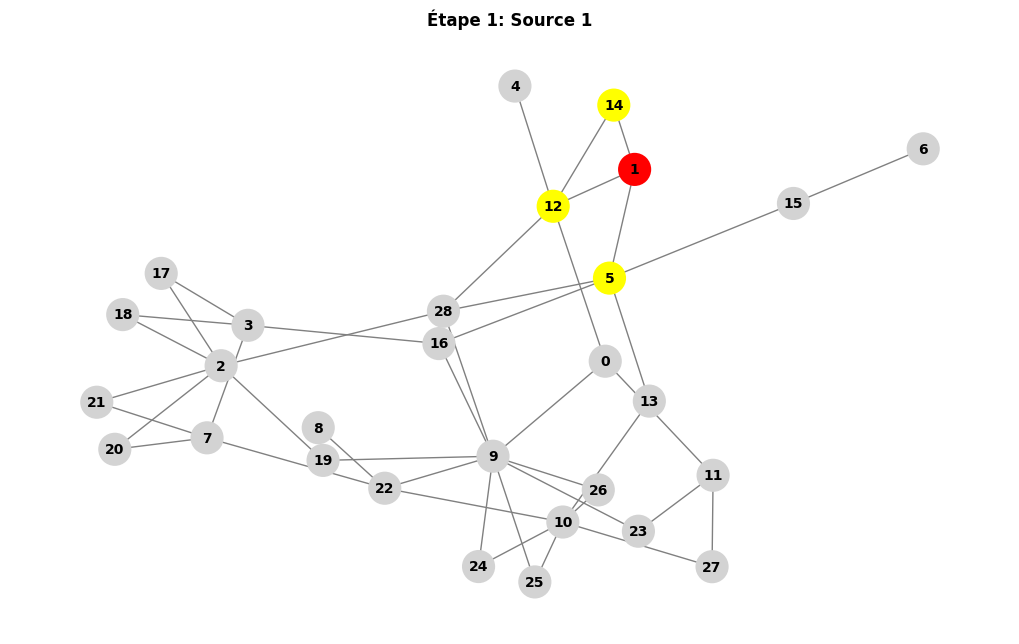

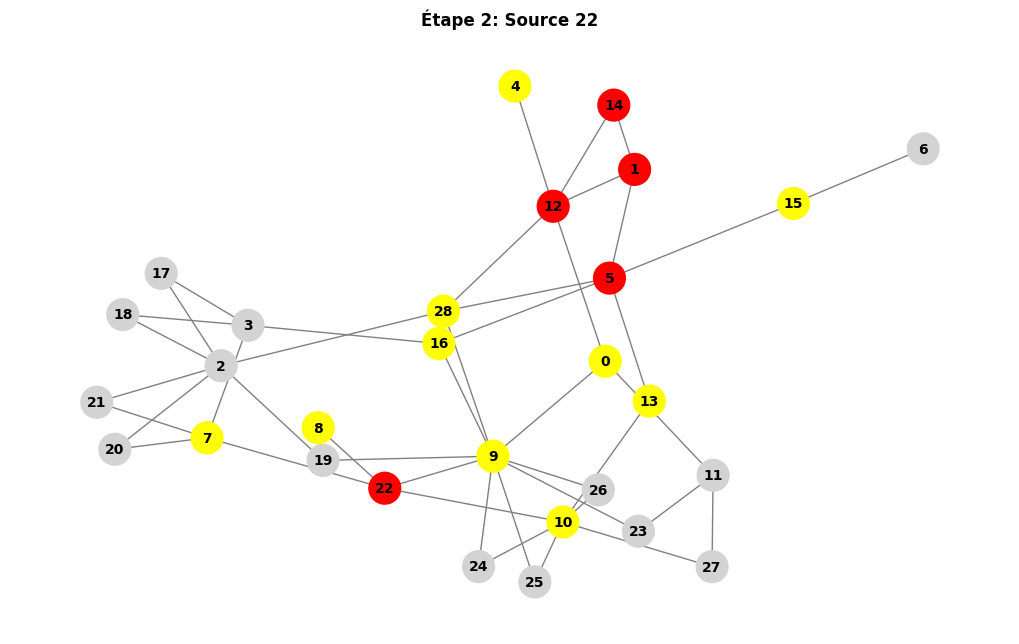

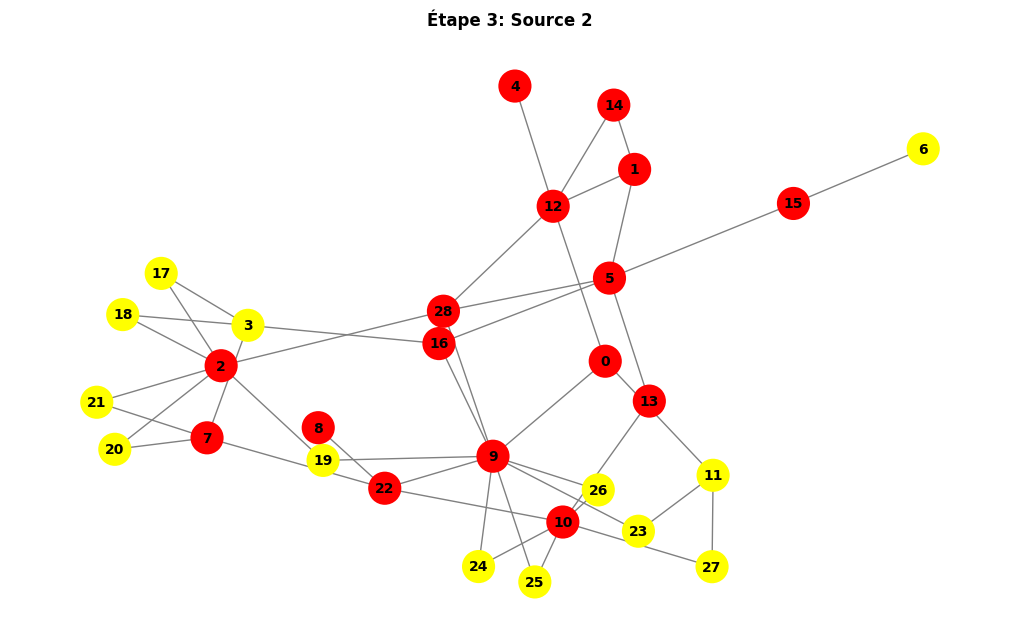

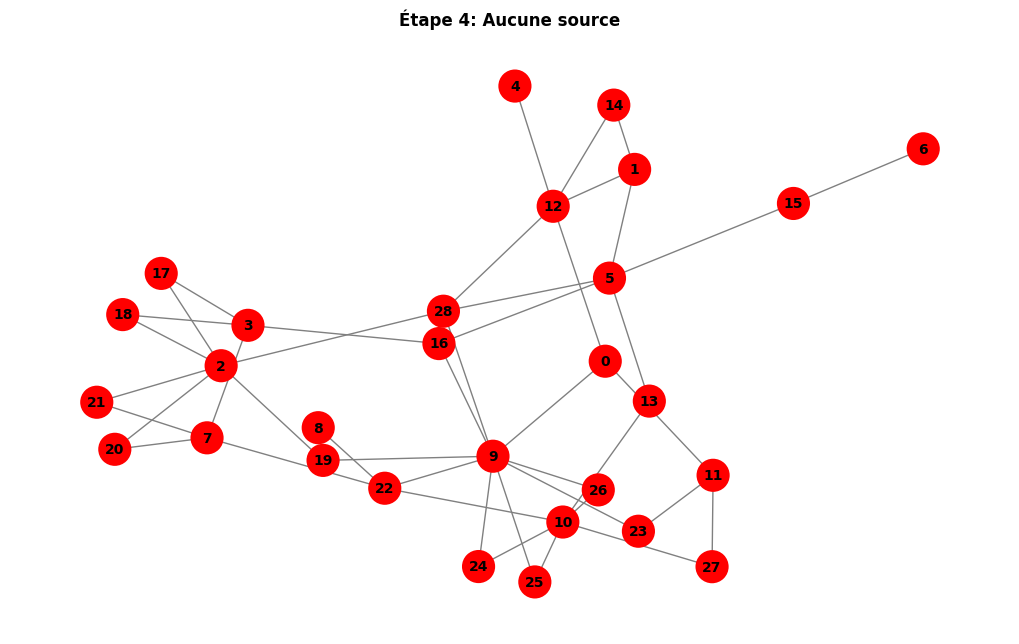

In [141]:
visualiser_graphe_par_etape(graphe, [1, 22, 2])
